# Supplemental Figure S6: CV for Flank-WC and non-WC at different coverage thresholds

# Setup

## imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

from dms_3d_features.plotting import *

## extra functions

In [6]:
def get_second_stack_cv_df(df):
    """
    Process input dataframe to compute coefficient of variation (CV)
    for second stack, and return combined results.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing columns:
        ['m_sequence', 'r_loc_pos', 'm_second_flank_bp_5p', 'm_second_flank_bp_3p',
         'm_token', 'likely_pair', 'm_flank_bp_5p', 'm_flank_bp_3p',
         'p5_res', 'p3_res', 'r_stack', 'ln_r_data', 'r_data', 'r_type']
    randomized_csv : str
        Path to store/reuse randomized CV results.

    Returns
    -------
    df_all : pd.DataFrame
        Combined dataframe with CV values and data_type labels.
    """
    df = df.copy()
    df["r_type"] = df["r_type"].replace("Flank-WC", "WC")

    # Aggregate per second stack
    df_second_stack = (
        df.groupby(
            ["m_sequence", "r_loc_pos", "m_second_flank_bp_5p", "m_second_flank_bp_3p"]
        )
        .agg(
            m_token=("m_token", "first"),
            likely_pair=("likely_pair", "first"),
            m_flank_bp_5p=("m_flank_bp_5p", "first"),
            m_flank_bp_3p=("m_flank_bp_3p", "first"),
            p5_res=("p5_res", "first"),
            p3_res=("p3_res", "first"),
            r_stack=("r_stack", "first"),
            mean_ln_r_data=("ln_r_data", "mean"),
            std_ln_r_data=("ln_r_data", "std"),
            cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
            count=("ln_r_data", "count"),
            r_type=("r_type", "first"),
            num_aligned=("num_aligned", "first"),
        )
        .reset_index()
    )

    # CV for all data
    df_cv = (
        df.groupby(["m_sequence", "r_loc_pos"])
        .agg(
            cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
            r_type=("r_type", "first"),
            num_aligned=("num_aligned", "first"),
            count=("ln_r_data", "count"),
        )
        .reset_index()
    )
    df_cv = df_cv.query("count >= 5").copy()
    df_cv["data_type"] = "all"

    # Second stack subset make sure there are at least 5 entries or CV will be really low
    df_second_stack_cv = df_second_stack.query("count >= 5").copy()
    df_second_stack_cv["data_type"] = "Second Stack"

    # Combine results
    df_all = pd.concat([df_second_stack_cv, df_cv]).reset_index(drop=True)

    return df_all

## load data

In [7]:
DATA_PATH = "../../data"
REVISION_PATH = "../../data/revisions"

In [8]:
dfs = []
for fn in glob.glob(
    f"{REVISION_PATH}/dif_threshold/residues/pdb_library_1_residues_*.json"
):
    if "avg" in fn:
        continue
    df = pd.read_json(fn)
    with np.errstate(divide="ignore"):
        df["ln_r_data"] = np.log(df["r_data"])
    df["ln_r_data"] = df["ln_r_data"].replace(-np.inf, -9.8)
    df = df.query("r_data_outlier == False").copy()
    df["num_aligned"] = int(fn.split("_")[-1].split(".")[0])
    dfs.append(df)
df_cov_threshold = pd.concat(dfs)

# Plotting

In [9]:
dfs = []
for num_aligned, g in df_cov_threshold.groupby("num_aligned"):
    dfs.append(get_second_stack_cv_df(g))
df_cv_all = pd.concat(dfs)

summary = (
    df_cv_all.groupby(["num_aligned", "r_type", "data_type"])
    .agg(
        cv_r_data=("cv_r_data", "mean"),
        cv_r_data_std=("cv_r_data", "std"),
        count=("cv_r_data", "count"),
    )
    .reset_index()
)

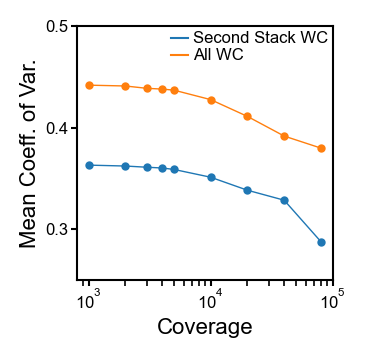

In [10]:
def plot_wc_cv_vs_coverage(df, ax):
    summary_1 = df.query("data_type == 'Second Stack' and r_type == 'WC'")
    summary_2 = df.query("data_type == 'all' and r_type == 'WC'")
    ax.plot(
        summary_1["num_aligned"],
        summary_1["cv_r_data"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="Second Stack",
    )
    ax.plot(
        summary_2["num_aligned"],
        summary_2["cv_r_data"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="All",
    )
    ax.set_xlabel("Coverage", labelpad=2)
    ax.set_ylabel("Mean Coeff. of Var.", labelpad=2)
    ax.set_ylim(0.25, 0.5)
    ax.set_xscale("log")
    ax.set_xticks([1000, 10000, 100000])
    add_legend(ax, ["Second Stack WC", "All WC"])
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(1, 1, figsize=(1.65, 1.65), dpi=200)
plot_wc_cv_vs_coverage(summary, ax)

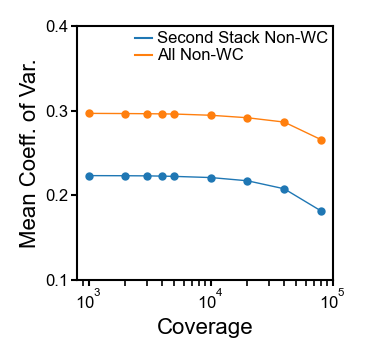

In [11]:
def plot_nonwc_cv_vs_coverage(df, ax):
    summary_1 = df.query("data_type == 'Second Stack' and r_type == 'NON-WC'")
    summary_2 = df.query("data_type == 'all' and r_type == 'NON-WC'")
    ax.plot(
        summary_1["num_aligned"],
        summary_1["cv_r_data"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="Second Stack",
    )
    ax.plot(
        summary_2["num_aligned"],
        summary_2["cv_r_data"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="All",
    )
    ax.set_xlabel("Coverage", labelpad=2)
    ax.set_ylabel("Mean Coeff. of Var.", labelpad=2)
    ax.set_xscale("log")
    ax.set_xticks([1000, 10000, 100000])
    ax.set_ylim(0.10, 0.4)
    add_legend(ax, ["Second Stack Non-WC", "All Non-WC"])
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(1, 1, figsize=(1.65, 1.65), dpi=200)
plot_nonwc_cv_vs_coverage(summary, ax)

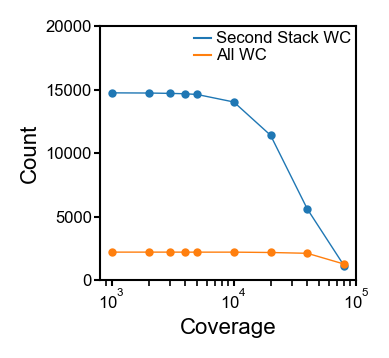

In [12]:
def plot_wc_count_vs_coverage(df, ax):
    summary_1 = df.query("data_type == 'Second Stack' and r_type == 'WC'")
    summary_2 = df.query("data_type == 'all' and r_type == 'WC'")
    ax.plot(
        summary_1["num_aligned"],
        summary_1["count"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="Second Stack",
    )
    ax.plot(
        summary_2["num_aligned"],
        summary_2["count"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="All",
    )
    ax.set_xlabel("Coverage", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    ax.set_xscale("log")
    ax.set_xticks([1000, 10000, 100000])
    ax.set_ylim(0, 20000)
    add_legend(ax, ["Second Stack WC", "All WC"])
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(1, 1, figsize=(1.65, 1.65), dpi=200)
plot_wc_count_vs_coverage(summary, ax)

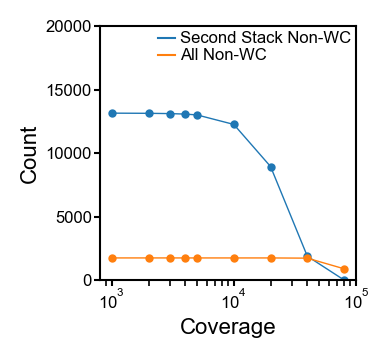

In [13]:
def plot_nonwc_count_vs_coverage(df, ax):
    summary_1 = df.query("data_type == 'Second Stack' and r_type == 'NON-WC'")
    summary_2 = df.query("data_type == 'all' and r_type == 'NON-WC'")
    ax.plot(
        summary_1["num_aligned"],
        summary_1["count"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="Second Stack",
    )
    ax.plot(
        summary_2["num_aligned"],
        summary_2["count"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="All",
    )
    ax.set_xlabel("Coverage", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    ax.set_xscale("log")
    ax.set_xticks([1000, 10000, 100000])
    ax.set_ylim(0, 20000)
    add_legend(ax, ["Second Stack Non-WC", "All Non-WC"])
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


# Example usage:
fig, ax = plt.subplots(1, 1, figsize=(1.65, 1.65), dpi=200)
plot_nonwc_count_vs_coverage(summary, ax)

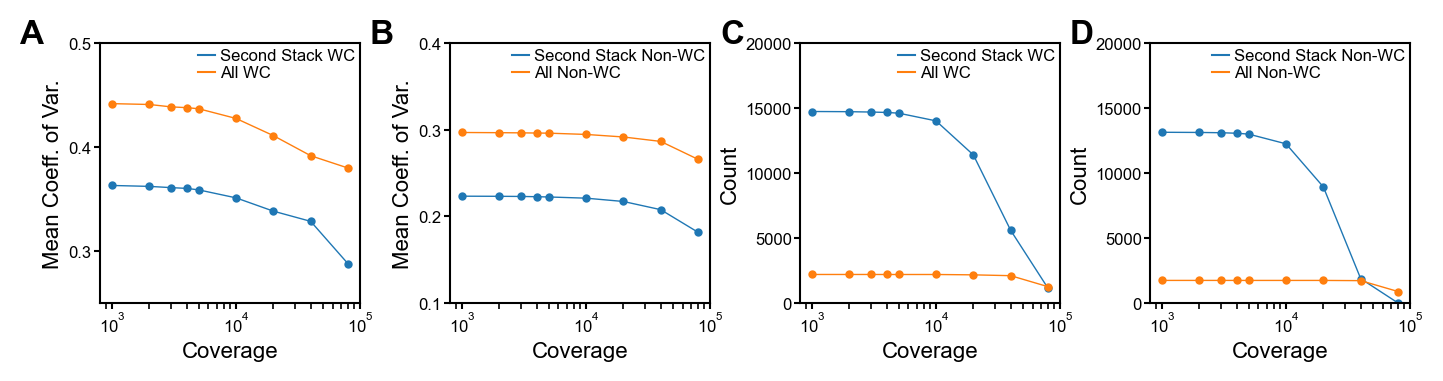

In [14]:
fig_size = (7, 6)
layout = (1, 4)
subplot_size = (1.3, 1.3)
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.40, "right": 0.0, "top": 0.0, "bottom": 0.70},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
fig = plt.figure(figsize=fig_size, dpi=200)
ax1 = fig.add_axes(coords_list[0])
plot_wc_cv_vs_coverage(summary, ax1)

ax2 = fig.add_axes(coords_list[1])
plot_nonwc_cv_vs_coverage(summary, ax2)

ax3 = fig.add_axes(coords_list[2])
plot_wc_count_vs_coverage(summary, ax3)

ax4 = fig.add_axes(coords_list[3])
plot_nonwc_count_vs_coverage(summary, ax4)
add_subplot_labels(fig, coords_list)
fig.savefig(
    "../../figures/supplemental_figures/supplemental_figure_s6.png",
    bbox_inches="tight",
    dpi=600,
)